# Initial Cleaning

In [190]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import copy
from scipy.signal import find_peaks
import scipy

In [191]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [192]:
demand_df

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148805,2020-09-30 22:45:00,96.9,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
148806,2020-09-30 23:00:00,96.9,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
148807,2020-09-30 23:15:00,37.4,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62
148808,2020-09-30 23:30:00,37.4,9.6,415.0,NaN,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94


In [193]:
# Hai's Filling Missing Values Function
def fill_missing(df):
    arr = []
    for col in df.columns:
        df[col] = df[col].fillna(df.mean(axis=1))
        arr += list(df[col])
    return arr

number of 15 min intervals in year 1: 35040
number of 15 min intervals in year 2: 35040
number of 15 min intervals in year 3: 35040
number of 15 min intervals in year 4: 35136


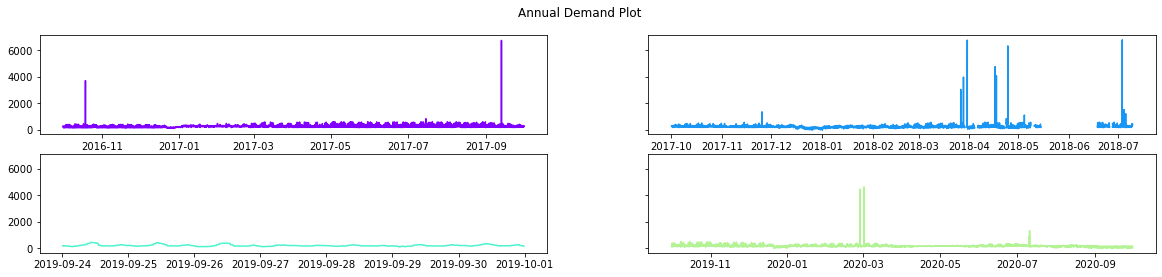

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
#create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 4), sharey=True)
color=cm.rainbow(np.linspace(0,1,6))
years = ['2016', '2017', '2018', '2019', '2020']
i = 1
building_df = pd.DataFrame()
for ax, c in zip(axes.flatten(), color):
    #generate start and end dates
    start_date = years[i-1] + '-09-30 23:45:00'
    end_date = years[i] + '-09-30 23:45:00'
    mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
    ax.plot(demand_df.loc[mask]['Date'], demand_df.loc[mask]['Building0'], color=c)
    building_df['year'+str(i)] = copy.copy(demand_df.loc[mask]['Building0'].reset_index(drop=True))
    print("number of 15 min intervals in year "+str(i)+": "+str(len(demand_df.loc[mask]['Building0'])))
    i += 1
fig.suptitle("Annual Demand Plot")
plt.show()

start_date = '2016-09-30 23:45:00'
end_date = '2020-09-29 23:45:00' #decrease 1 day due to leap year
mask = (demand_df['Date'] > start_date) & (demand_df['Date'] <= end_date)
demand_df.loc[mask, 'Building0'] = fill_missing(building_df)
demand_df.head()

In [195]:
# Hai's Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building0'], height=700)
Building0_peaks = np.zeros(len(demand_df))
Building0_peaks[:] = np.NaN
for i in peaks:
    Building0_peaks[i] = demand_df['Building0'][i]

# save smoothed demand_df
demand_df['Building0'] = smooth_like_butter(peaks, demand_df['Building0'])
demand_df.to_csv("demand_smoothed_building0")

# Autoregressive Forecasting Setup 

In [196]:
# Auto Regressive Forecasting
# https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

# imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#demand_df = pd.read_csv("demand_smoothed_building0", parse_dates=["Date"])
demand_df.head()

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# Remove empty rows
demand_df["Building0"].replace("", np.nan, inplace=True) # replaces empty string
demand_df.dropna(subset=["Building0"], inplace=True) # removes nan rows

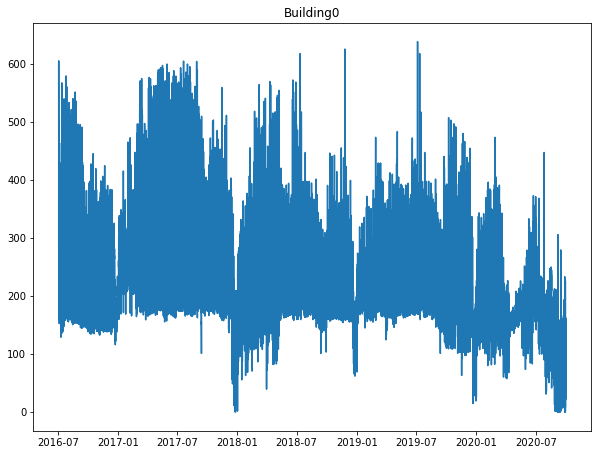

In [198]:
# Plot time series
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.show()

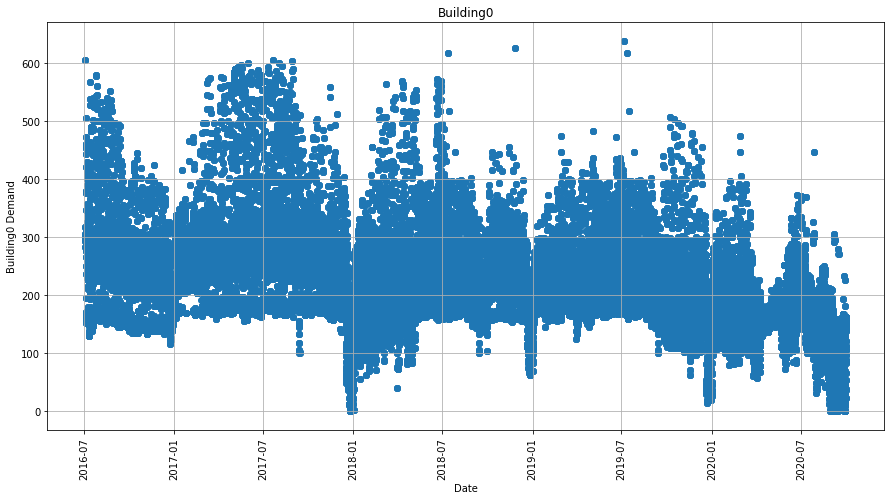

In [199]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.ylabel("Building0 Demand")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [200]:
# Need to store first value of building 0 for later
building0_first = demand_df["Building0"].iloc[0]
print("First building0 value is: " + str(building0_first))

# AR(p) process requires stationary data, so let's take the log difference to make it stationary
demand_df["Building0"] = np.log(demand_df["Building0"])
demand_df["Building0"] = demand_df['Building0'].diff()
demand_df = demand_df.drop(demand_df.index[0])
demand_df

First building0 value is: 283.8


,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
1,2016-07-03 21:45:00,0.000000,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,0.000000,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,0.758610,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,0.000000,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-07-03 22:45:00,0.000000,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148805,2020-09-30 22:45:00,0.000000,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
148806,2020-09-30 23:00:00,0.000000,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
148807,2020-09-30 23:15:00,-0.952009,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62
148808,2020-09-30 23:30:00,0.000000,9.6,415.0,NaN,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94


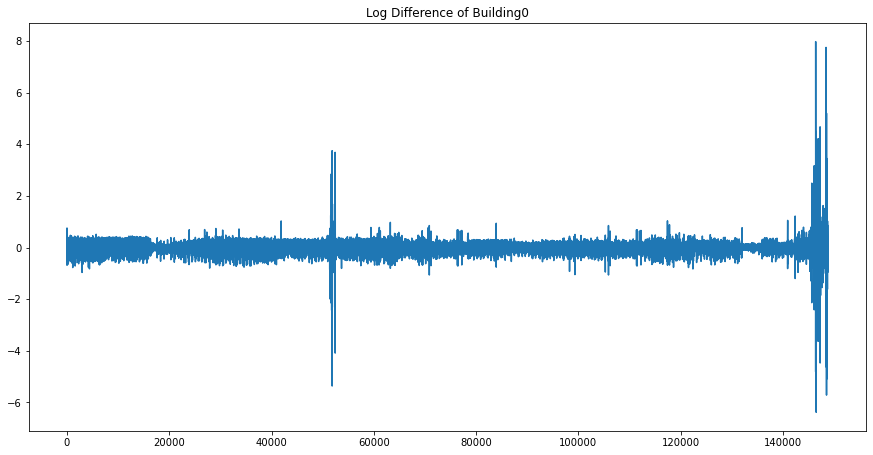

In [201]:
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Building0"])
plt.title("Log Difference of Building0")
plt.show()

Now the data appears to have no trend, but to ensure how stationary the data is we can use the Dick-Fuller test for statistical significance.

In [202]:
ad_fuller_result = adfuller(demand_df["Building0"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -100.13853121065516
p-value: 0.0


As we have a very large, negative ADF statistic and an extremely low p-value of 0 - we can reject the null hypothesis and say that our time series is stationary.

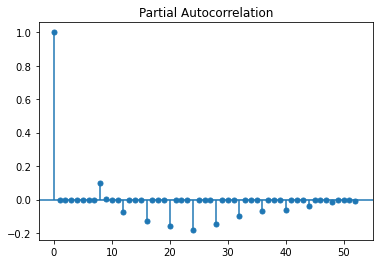

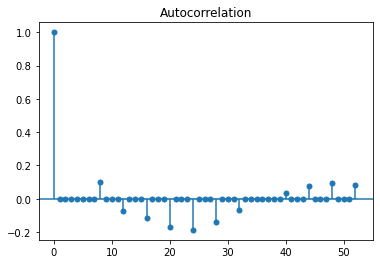

In [203]:
# Plot autocorrelation and partial autocorrelation plots
plot_pacf(demand_df["Building0"]);
plot_acf(demand_df["Building0"]);

Coefficients are least important after lag 1, now use a Yule-Walker equation to estimate of AR(p) of order 1

Other options include:

Coefficients are least important after lag 8, now use a Yule-Walker equation to estimate of AR(p) of order 8

Coefficients are least important after lag 33, now use a Yule-Walker equation to estimate of AR(p) of order 33

Coefficients are least important after lag 39, now use a Yule-Walker equation to estimate of AR(p) of order 39

Coefficients are least important after lag 43, now use a Yule-Walker equation to estimate of AR(p) of order 43

# Autoregressive Model of Order 1

In [204]:
# Function for fitting:
def find_predicted_val(rho, sigma, starting_val, df_col):
    res = sigma
    j = starting_val
    for i in range(len(rho)):
        res += rho[i]*df_col[j - i]
        j += 1
    return res

In [205]:
# Try a AR(1) model
rho_AR1, sigma_AR1 = yule_walker(demand_df["Building0"], 1)
print(f'rho: {-rho_AR1}')
print(f'sigma: {sigma_AR1}')

rho: [0.00166727]
sigma: 0.10147121133129801


Therefore, the function is best approximated for:

y_t = 0.10 + 1.67 * 10^-3 * y_t-1

In [206]:
# Fitting the AR(1) model

demand_df_AR1 = copy.copy(demand_df[["Date","Building0"]])

for i in range(len(demand_df["Date"]) - 1, len(demand_df["Date"]) + 15000 - 1):
    if i % 1000 == 0:
        print(i)
    demand_df_AR1 = demand_df_AR1.append({"Building0" : sigma_AR1 + find_predicted_val(rho_AR1, sigma_AR1, i, demand_df_AR1["Building0"])}, ignore_index=True)

149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000


In [207]:
demand_df_AR1["Building0"][148809:163809].unique()

array([0.20294242, 0.20260406, 0.20260463, 0.20260463, 0.20260463,
       0.20260463])

In [208]:
demand_df_AR1

,Date,Building0
0,2016-07-03 21:45:00,0.000000
1,2016-07-03 22:00:00,0.000000
2,2016-07-03 22:15:00,0.758610
3,2016-07-03 22:30:00,0.000000
4,2016-07-03 22:45:00,0.000000
...,...,...
163804,NaT,0.202605
163805,NaT,0.202605
163806,NaT,0.202605
163807,NaT,0.202605


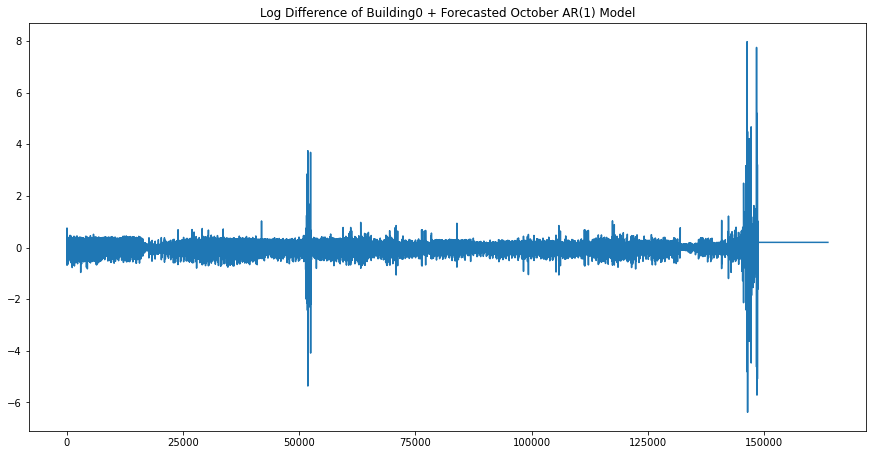

In [209]:
# Plotting AR(1) model
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR1["Building0"])
plt.title("Log Difference of Building0 + Forecasted October AR(1) Model")
plt.show()

In [210]:
# Now we need to try and inverse our log difference function by defining this function
demand_df = pd.read_csv("demand_smoothed_building0", parse_dates=["Date"])


def inverse_log_diff(first_value, df_col):
    df_col.iat[0] = np.log(first_value)
    res = np.exp(df_col.cumsum())
    return res

demand_df_AR1["Building0"] = inverse_log_diff(building0_first, demand_df_AR1["Building0"])

C:\Users\User\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [211]:
demand_df_AR1

,Date,Building0
0,2016-07-03 21:45:00,283.8
1,2016-07-03 22:00:00,283.8
2,2016-07-03 22:15:00,606.0
3,2016-07-03 22:30:00,606.0
4,2016-07-03 22:45:00,606.0
...,...,...
163804,NaT,inf
163805,NaT,inf
163806,NaT,inf
163807,NaT,inf


In [212]:
demand_df_AR1.isnull().values.any()

True

In [213]:
# Plot time series
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR1["Building0"][14809:163808])
plt.title("Building0")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

# Autoregressive Model of Order 8

In [24]:
# Try a AR(8) model
rho_AR8, sigma_AR8 = yule_walker(demand_df["Building0"], 8)
print(f'rho: {-rho_AR8}')
print(f'sigma: {sigma_AR8}')

rho: [ 0.00163907 -0.00231315 -0.00029209  0.000119   -0.00024573  0.00372264
 -0.0002599  -0.09688429]
sigma: 0.10203902535022882


Therefore, the function is best approximated for:

y_t = 0.10 + 1.67 * 10^-3 * y_t-1 + 6.77 * 10^-4 * y_t-2 -2.88 * 10^-4 * t_y-3 etc

In [131]:
# Fitting the AR(8) model

demand_df_AR8 = demand_df[["Date", "Building0"]]

for i in range(len(demand_df["Date"]) - 1, len(demand_df["Date"]) + 15000 - 1):
    if i % 1000 == 0:
        print(i)
    demand_df_AR8 = demand_df_AR8.append({"Building0" : find_predicted_val(rho_AR8, sigma_AR8, i, demand_df_AR8["Building0"])}, ignore_index=True)

149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000


In [26]:
demand_df_AR8

,Date,Building0
0,2016-07-03 21:45:00,5.64827
1,2016-07-03 22:00:00,0.00000
2,2016-07-03 22:15:00,0.75861
3,2016-07-03 22:30:00,0.00000
4,2016-07-03 22:45:00,0.00000
...,...,...
163804,NaT,0.11269
163805,NaT,0.11269
163806,NaT,0.11269
163807,NaT,0.11269


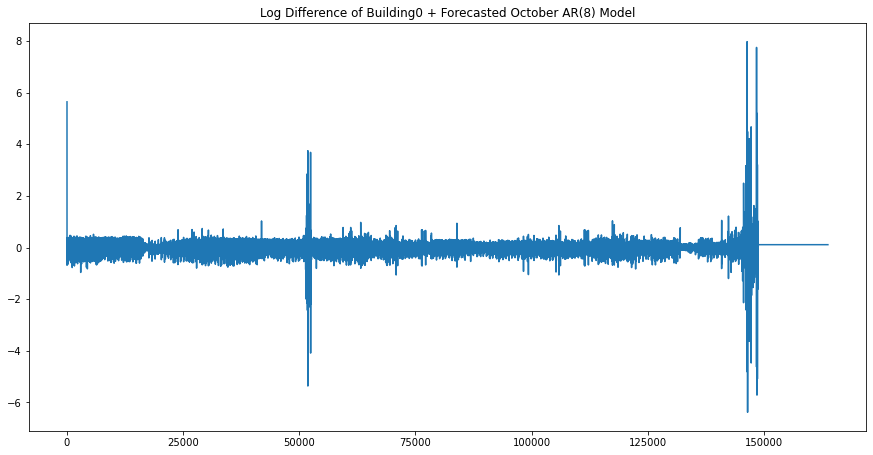

In [27]:
# Plotting AR(1) model
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR8["Building0"])
plt.title("Log Difference of Building0 + Forecasted October AR(8) Model")
plt.show()

# Autoregressive Model of Order 33

In [28]:
# Try a AR(33) model
rho_AR33, sigma_AR33 = yule_walker(demand_df["Building0"], 33)
print(f'rho: {-rho_AR33}')
print(f'sigma: {sigma_AR33}')

rho: [ 2.33343174e-03 -2.28958347e-03  2.61061318e-04  8.82257627e-02
  3.39211980e-04  3.92235003e-03  1.60633729e-04 -3.52263383e-02
 -7.46005961e-04  8.15124131e-04  1.96872606e-04  9.27519221e-02
  7.40183966e-04 -4.73110019e-04  1.60181167e-04  1.26045769e-01
  1.33005995e-03  4.75756074e-04  2.72493184e-04  1.57231839e-01
  8.36484064e-04 -1.34359684e-04  3.02303056e-04  1.79656158e-01
  4.24650723e-04  1.89118713e-04  5.50724273e-04  1.50414732e-01
  8.27819628e-04  9.25463963e-04  2.60093287e-04  9.49046345e-02
  5.16567660e-04]
sigma: 0.09671396929792171


In [29]:
# Fitting the AR(33) model

demand_df_AR33 = demand_df[["Date", "Building0"]]

for i in range(len(demand_df["Date"]) - 1, len(demand_df["Date"]) + 15000 - 1):
    if i % 1000 == 0:
        print(i)
    demand_df_AR33 = demand_df_AR8.append({"Building0" : find_predicted_val(rho_AR33, sigma_AR33, i, demand_df_AR33["Building0"])}, ignore_index=True)

149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000


In [30]:
demand_df_AR33

,Date,Building0
0,2016-07-03 21:45:00,5.648270
1,2016-07-03 22:00:00,0.000000
2,2016-07-03 22:15:00,0.758610
3,2016-07-03 22:30:00,0.000000
4,2016-07-03 22:45:00,0.000000
...,...,...
163805,NaT,0.112690
163806,NaT,0.112690
163807,NaT,0.112690
163808,NaT,0.112690


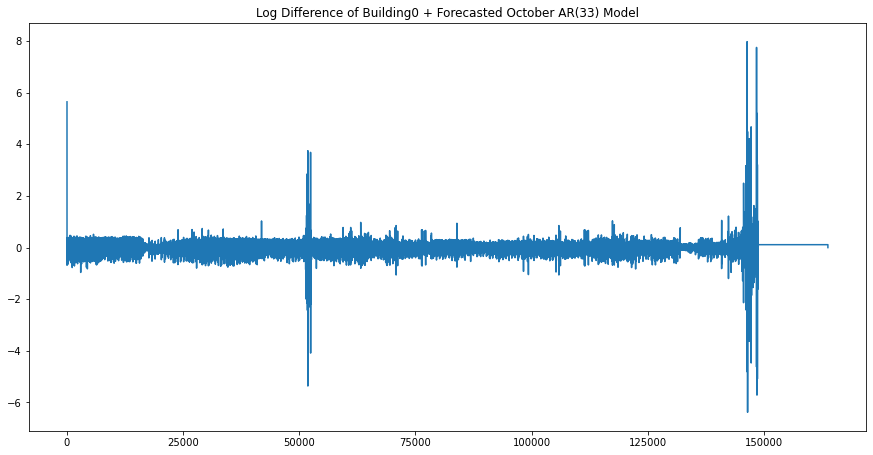

In [31]:
# Plotting AR(33) model
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR33["Building0"])
plt.title("Log Difference of Building0 + Forecasted October AR(33) Model")
plt.show()

# Autoregressive Model of Order 39

In [32]:
# Try a AR(39) model
rho_AR39, sigma_AR39 = yule_walker(demand_df["Building0"], 39)
print(f'rho: {-rho_AR39}')
print(f'sigma: {sigma_AR39}')

rho: [ 2.40786543e-03 -1.98671364e-03  4.18487973e-04  9.45292275e-02
  3.83263247e-04  4.31979539e-03  4.07053370e-04 -2.52384026e-02
 -6.82672574e-04  1.24771114e-03  4.67666462e-04  1.04678713e-01
  8.00905177e-04 -3.73753102e-05  4.58411109e-04  1.36484463e-01
  1.38883136e-03  8.88830362e-04  5.64637261e-04  1.65599935e-01
  8.83825143e-04  1.38081085e-04  5.09273285e-04  1.85814627e-01
  4.68019838e-04  3.32084706e-04  5.26863526e-04  1.48083313e-01
  8.47083406e-04  1.29355792e-03  3.50087174e-04  1.00763565e-01
  5.60572334e-04  1.36350017e-03  1.10632977e-03  6.63808259e-02
  1.80445357e-04  1.16194859e-03  5.39362656e-04]
sigma: 0.09650042830189018


In [33]:
# Fitting the AR(39) model

demand_df_AR39 = demand_df[["Date", "Building0"]]

for i in range(len(demand_df["Date"]) - 1, len(demand_df["Date"]) + 15000 - 1):
    if i % 1000 == 0:
        print(i)
    demand_df_AR39 = demand_df_AR39.append({"Building0" : find_predicted_val(rho_AR39, sigma_AR39, i, demand_df_AR39["Building0"])}, ignore_index=True)

149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000


In [34]:
demand_df_AR39

,Date,Building0
0,2016-07-03 21:45:00,5.648270
1,2016-07-03 22:00:00,0.000000
2,2016-07-03 22:15:00,0.758610
3,2016-07-03 22:30:00,0.000000
4,2016-07-03 22:45:00,0.000000
...,...,...
163804,NaT,0.048289
163805,NaT,0.048289
163806,NaT,0.048289
163807,NaT,0.048289


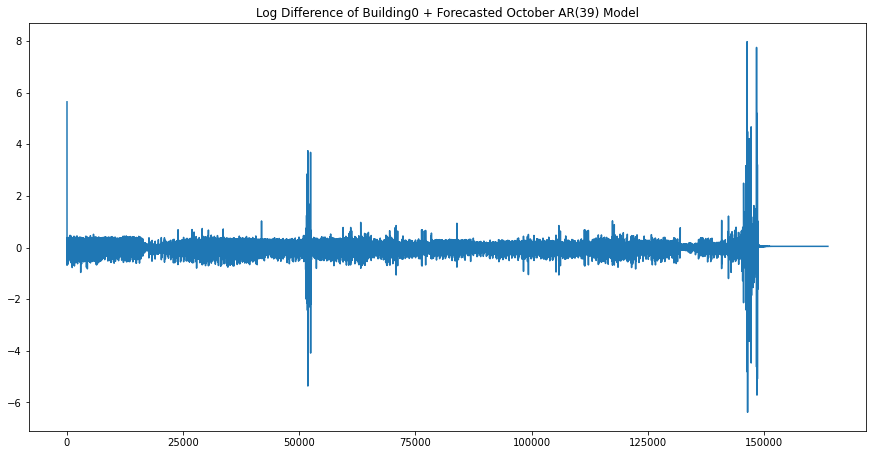

In [35]:
# Plotting AR(39) model
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR39["Building0"])
plt.title("Log Difference of Building0 + Forecasted October AR(39) Model")
plt.show()

# Autoregressive Model of Order 43

In [36]:
# Try a AR(43) model
rho_AR43, sigma_AR43 = yule_walker(demand_df["Building0"], 44)
print(f'rho: {-rho_AR43}')
print(f'sigma: {sigma_AR43}')

rho: [ 2.47961128e-03 -1.89517119e-03  4.66559503e-04  1.00528874e-01
  5.07612714e-04  4.45541449e-03  4.75048083e-04 -1.67569073e-02
 -5.75906874e-04  1.40444070e-03  5.73068499e-04  1.16915144e-01
  9.16663740e-04  6.79443925e-05  5.72281439e-04  1.52875215e-01
  1.53112519e-03  9.55969077e-04  7.04135585e-04  1.82175630e-01
  1.02182415e-03  2.40864021e-04  6.87776978e-04  2.00020868e-01
  5.88228806e-04  3.98321479e-04  6.78208744e-04  1.59430852e-01
  9.46527210e-04  1.39545741e-03  3.81275409e-04  1.03227123e-01
  5.95352498e-04  1.66187412e-03  1.10303747e-03  7.13095709e-02
  2.68870420e-04  1.22200743e-03  7.32184762e-04  6.26733489e-02
  4.80002635e-04  1.70334661e-04  4.32788629e-04  3.48908536e-02]
sigma: 0.0962722958971256


In [37]:
# Fitting the AR(43) model

demand_df_AR43 = demand_df[["Date", "Building0"]]

for i in range(len(demand_df["Date"]) - 1, len(demand_df["Date"]) + 15000 - 1):
    if i % 1000 == 0:
        print(i)
    demand_df_AR43 = demand_df_AR43.append({"Building0" : find_predicted_val(rho_AR43, sigma_AR43, i, demand_df_AR43["Building0"])}, ignore_index=True)

149000
150000
151000
152000


<ipython-input-16-536f57ba5334>:6: RuntimeWarning: overflow encountered in double_scalars
  res += rho[i]*df_col[j - i]
<ipython-input-16-536f57ba5334>:6: RuntimeWarning: invalid value encountered in double_scalars
  res += rho[i]*df_col[j - i]


153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000


In [38]:
demand_df_AR43

,Date,Building0
0,2016-07-03 21:45:00,5.64827
1,2016-07-03 22:00:00,0.00000
2,2016-07-03 22:15:00,0.75861
3,2016-07-03 22:30:00,0.00000
4,2016-07-03 22:45:00,0.00000
...,...,...
163804,NaT,NaN
163805,NaT,NaN
163806,NaT,NaN
163807,NaT,NaN


In [39]:
# Plotting AR(43) model
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df_AR43["Building0"])
plt.title("Log Difference of Building0 + Forecasted October AR(43) Model")
plt.show()

C:\Users\User\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2563: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin


IndexError: index 0 is out of bounds for axis 0 with size 0